In [ ]:
!pip install kaggle
!mkdir kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import json 
kaggleAPIToken = {"username":"lephanvanviet","key":"5ce69bf8b6c7991dd0cdf4c0731e2f39"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(kaggleAPIToken, file)

In [ ]:
!chmod 600 /content/kaggle/kaggle.json
!sudo mkdir ~/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d lephanvanviet/venom-and-nonvenom

 98% 939M/953M [00:07<00:00, 111MB/s] 
100% 953M/953M [00:07<00:00, 136MB/s]


In [ ]:
!unzip /content/venom-and-nonvenom.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/NonVenom/Image_nonvenom_600.jpg  
  inflating: train/NonVenom/Image_nonvenom_601.jpg  
  inflating: train/NonVenom/Image_nonvenom_602.jpg  
  inflating: train/NonVenom/Image_nonvenom_603.jpg  
  inflating: train/NonVenom/Image_nonvenom_604.jpg  
  inflating: train/NonVenom/Image_nonvenom_605.jpg  
  inflating: train/NonVenom/Image_nonvenom_606.jpg  
  inflating: train/NonVenom/Image_nonvenom_607.jpg  
  inflating: train/NonVenom/Image_nonvenom_608.jpg  
  inflating: train/NonVenom/Image_nonvenom_609.jpg  
  inflating: train/NonVenom/Image_nonvenom_610.jpg  
  inflating: train/NonVenom/Image_nonvenom_611.jpg  
  inflating: train/NonVenom/Image_nonvenom_612.jpg  
  inflating: train/NonVenom/Image_nonvenom_613.jpg  
  inflating: train/NonVenom/Image_nonvenom_614.jpg  
  inflating: train/NonVenom/Image_nonvenom_615.jpg  
  inflating: train/NonVenom/Image_nonvenom_616.jpg  
  inflating: train/NonVenom/Image_nonvenom

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import re
import cv2
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
file = "/content/train/"
categories = ['NonVenom', 'Venomous']

In [ ]:
filenames_list = []
categories_list = []

df = df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list,
})

df = pd.DataFrame(columns= ['image_path','category'])

for category in categories:
    filenames = os.listdir(file + category+"/")
    for filename in filenames:
        file_path = file + category+"/"+filename
        df2 = {'image_path': file_path, 'category': category}
        df = df.append(df2, ignore_index = True)

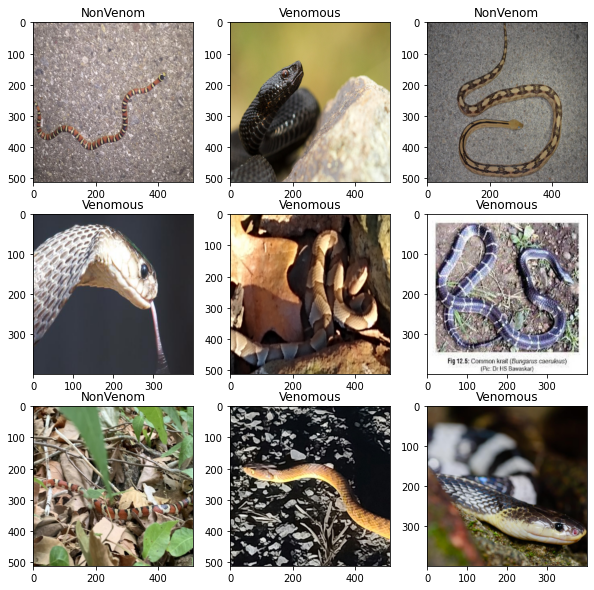

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(sample['image_path'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

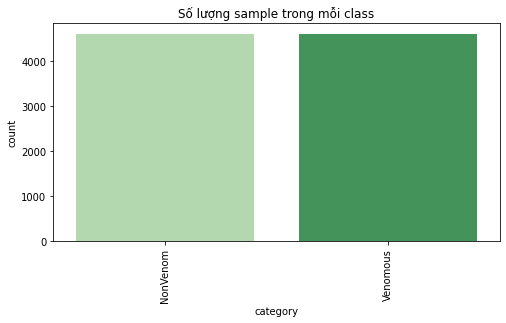

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x="category", data=df, palette='Greens')
plt.xticks(rotation=90)
plt.title('Số lượng sample trong mỗi class')
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
aug_train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         rotation_range=45,
                         brightness_range= [0.5, 1.0],
                         zoom_range=[0.5,1.0],
                         width_shift_range = 0.2,
                         height_shift_range = 0.2)
aug_val = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         rotation_range=45,
                         brightness_range= [0.5, 1.0],
                         zoom_range=[0.5,1.0],
                         width_shift_range = 0.2,
                         height_shift_range = 0.2)

aug_test = ImageDataGenerator(rescale=1./255)

In [ ]:
train_aug = aug_train.flow_from_dataframe(
                          dataframe=train_df,
                          directory=file,
                          x_col='image_path',
                          y_col='category',
                          target_size=(100, 100),
                          class_mode='categorical',
                          batch_size=128,
                          seed=42)
val_aug = aug_val.flow_from_dataframe(
                          dataframe=val_df,
                          directory=file,
                          x_col='image_path',
                          y_col='category',
                          target_size=(100, 100),
                          class_mode='categorical',
                          batch_size=128,
                          seed=42)
test_aug = aug_test.flow_from_dataframe(
                          dataframe=test_df,
                          directory=file,
                          x_col='image_path',
                          y_col='category',
                          target_size=(100, 100),
                          color_mode="rgb",
                          class_mode="categorical",
                          batch_size=1,
                          shuffle=False,
                          seed=42)

Found 7452 validated image filenames belonging to 2 classes.
Found 828 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [ ]:
sum_train_samples = train_aug.samples
sum_validation_samples = val_aug.samples
sum_test_samples = test_aug.samples


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten()) 
model.add(Dense(128,activation='relu')) 
model.add(Dense(128,activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(2,activation='sigmoid')) #Updated for number of classes


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 128)               5

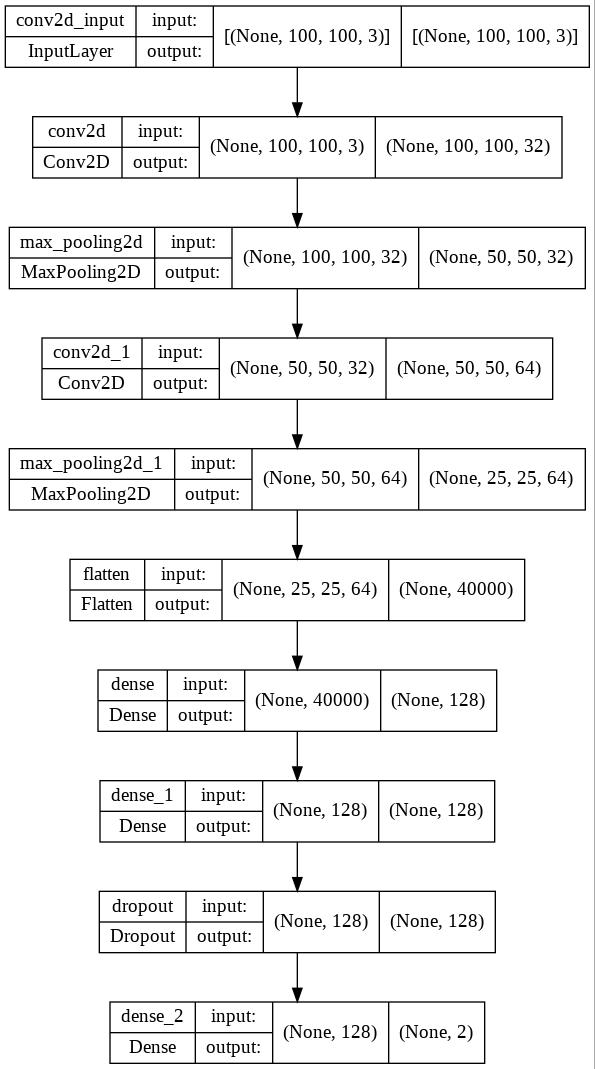

In [ ]:
tf.keras.utils.plot_model(model, 'model.jpg', show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks_list = [
    ModelCheckpoint(filepath='model.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)]

#Training
history = model.fit(
        train_aug,
        steps_per_epoch=sum_train_samples // 128,
        epochs=100,
        callbacks = callbacks_list,
        validation_data=val_aug,
        verbose = 1,
        validation_steps=sum_validation_samples // 128)

Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 1.0496 - accuracy: 0.4932
Epoch 1: val_loss improved from inf to 0.68971, saving model to model.h5
58/58 [==============================] - 70s 1s/step - loss: 1.0496 - accuracy: 0.4932 - val_loss: 0.6897 - val_accuracy: 0.5052
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5273
Epoch 2: val_loss improved from 0.68971 to 0.68031, saving model to model.h5
58/58 [==============================] - 70s 1s/step - loss: 0.6905 - accuracy: 0.5273 - val_loss: 0.6803 - val_accuracy: 0.5768
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5567
Epoch 3: val_loss improved from 0.68031 to 0.67897, saving model to model.h5
58/58 [==============================] - 71s 1s/step - loss: 0.6843 - accuracy: 0.5567 - val_loss: 0.6790 - val_accuracy: 0.5482
Epoch 4/100
58/58 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.5674
Epoch 

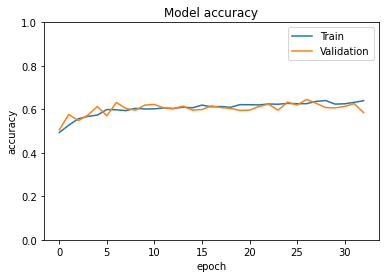

In [ ]:
Splt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'])
plt.ylim([0,1])
plt.show()

In [ ]:
score = model.evaluate(val_aug)
print('Test loss: %.4f'% score[0])
print('Test accuracy %.4f'% score[1])

7/7 [==============================] - 8s 1s/step - loss: 0.6203 - accuracy: 0.6365
Test loss: 0.6203
Test accuracy 0.6365


In [ ]:
score = model.evaluate(test_aug)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

920/920 [==============================] - 16s 17ms/step - loss: 0.6262 - accuracy: 0.6489
Test loss: 0.6261743307113647
Test accuracy: 0.6489130258560181


In [ ]:
from keras.models import load_model
import cv2 as cv
from keras.preprocessing.image import load_img, img_to_array

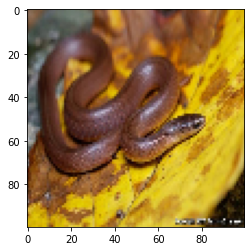

In [ ]:
img = load_img('Image_nonvenom_167.jpg',target_size=(100,100))
plt.imshow(img)

In [ ]:
model = load_model('model.h5')

In [ ]:
img = cv.imread('Image_nonvenom_233.jpg')
img = cv.resize(img,(100,100))
img = img.astype('float')*1./255
img = np.expand_dims(img, axis=0)

predict = model.predict(img)
# categories[np.argmax(predict[0])]
predict

array([[0.4503444 , 0.53182006]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
Y_pred = model.predict(test_aug)
y_pred = np.argmax(Y_pred, axis=1)
target_names = categories

# Confusion Matrix
cm = confusion_matrix(test_aug.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_aug.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    NonVenom       0.64      0.65      0.64       457
    Venomous       0.65      0.63      0.64       463

    accuracy                           0.64       920
   macro avg       0.64      0.64      0.64       920
weighted avg       0.64      0.64      0.64       920

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f361bab5d40> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 720x720 with 2 Axes>